In [ ]:
!pip install tensorflow==1.15.0

In [ ]:
from google.colab import auth
auth.authenticate_user()

!curl https://sdk.cloud.google.com | bash


!gcloud init

#Important: since 30.03.2022 running the above script will not produce adc.json file with credentials to the google cloud platform (Google changed that). Since then we had to upload our own credentials file each time. Without the working adc.json file the code will not work. 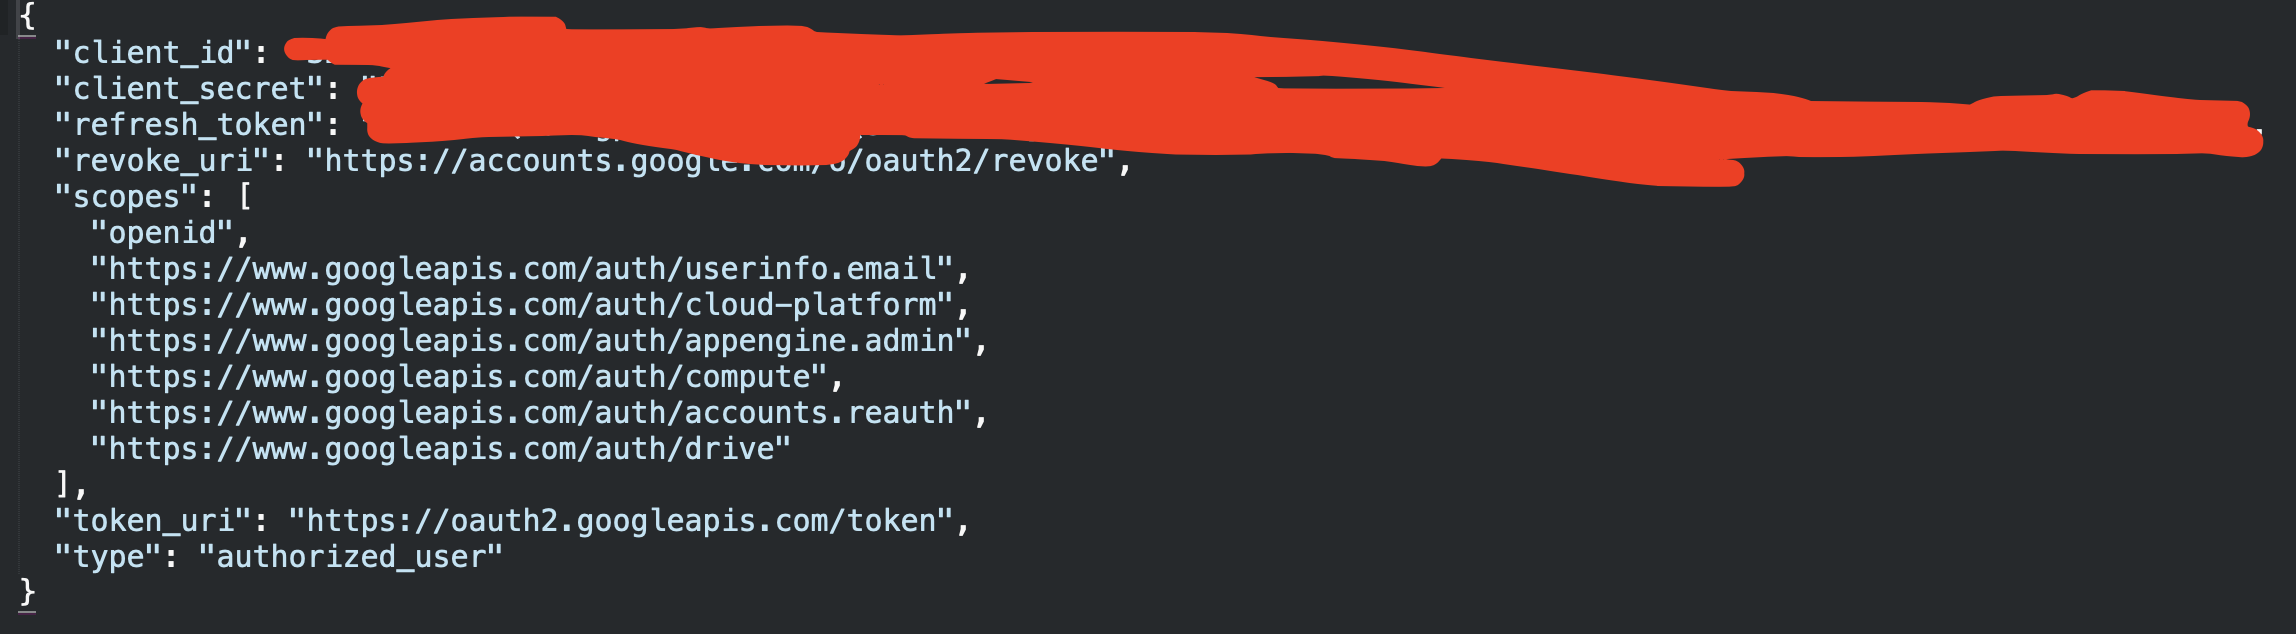

In [ ]:
!git clone https://github.com/google-research/bert

In [ ]:
psychBERT_1 = True #PsychBERT_long
psychBERT_2 = False #PsychBERT_con_long
folder_name = "Bert_Reddit"
if psychBERT_1:
    VOC_FNAME = 'vocab.txt'

elif psychBERT_2:

    VOC_FNAME = 'bert-reddit-vocab.txt'

#This should be true if the first step of the pretraining is done, it means the text is put into shards. 
shard_prepared = False
#If we want to train the tokenizer with the new vocabulary the variable train_tokenizer should be true 
train_tokenizer = True

In [ ]:
import os
import sys
import json
import nltk
import random
import logging
import tensorflow as tf
#import sentencepiece as spm
from glob import glob
from google.colab import auth, drive
from tensorflow.keras.utils import Progbar
sys.path.append("bert")
from bert import modeling, optimization, tokenization
from bert.run_pretraining import input_fn_builder, model_fn_builder
auth.authenticate_user() 
# configure logging
log = logging.getLogger('tensorflow')
log.setLevel(logging.INFO)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s :  %(message)s')
sh = logging.StreamHandler()
sh.setLevel(logging.INFO)
sh.setFormatter(formatter)
log.handlers = [sh]


if 'COLAB_TPU_ADDR' in os.environ:
  log.info("Using TPU runtime")
  USE_TPU = True
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']

  with tf.Session(TPU_ADDRESS) as session:
    log.info('TPU address is ' + TPU_ADDRESS)
    # Upload credentials to TPU.
    with open('/content/adc.json', 'r') as f:
      auth_info = json.load(f)
    tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
    
else:
  log.warning('Not connected to TPU runtime')
  USE_TPU = False

In [ ]:
#!gsutil cp  gs://masterthesisbert/{folder_name}/{VOC_FNAME} /content/
if psychBERT_2:
    !gsutil cp  gs://masterthesisbert/preprocessed_datasets_rightway/bert-reddit-vocab.txt /content/

elif psychBERT_1:  

    !gsutil cp gs://masterthesisbert/bert_model_BERT_RE/vocab.txt /content/

In [ ]:
!pip install transformers
!pip install tokenizers==0.7.0
!pip install datasets
import transformers

In [ ]:
bucket_name = 'masterthesisbert'
!mkdir preprocessed_datasets

In [ ]:
#!gsutil cp gs://{bucket_name}/dataset.txt /content
if shard_prepared==False: 
    if psychBERT_2:
        !gsutil -m cp  gs://masterthesisbert/preprocessed_datasets_rightway/red* /content/preprocessed_datasets/
    elif psychBERT_1:
        !gsutil -m cp  gs://masterthesisbert/preprocessed_datasets_rightway/* /content/preprocessed_datasets/

In [ ]:
if shard_prepared==False:

    import os

    arr = os.listdir("/content/preprocessed_datasets/")
    arr

In [ ]:
if shard_prepared==False:
    
    from inspect import formatannotationrelativeto
    from sqlite3.dbapi2 import threadsafety
    import shutil
    from pathlib import Path
    #merge all the files to one

    #depending on the corpus
    if psychBERT_1:
        data_files=['/content/preprocessed_datasets/bookcorpus.txt', '/content/preprocessed_datasets/reddit_text_1.txt',  '/content/preprocessed_datasets/reddit_text_2.txt',  '/content/preprocessed_datasets/reddit_text_3.txt',  '/content/preprocessed_datasets/reddit_text_4.txt',  '/content/preprocessed_datasets/reddit_text_5.txt',  '/content/preprocessed_datasets/reddit_text_6.txt',  '/content/preprocessed_datasets/reddit_text_7.txt', '/content/preprocessed_datasets/wikipedia_preprocessed_1.txt', '/content/preprocessed_datasets/wikipedia_preprocessed_2.txt', "/content/preprocessed_datasets/reddit_text_google_1.txt", "/content/preprocessed_datasets/reddit_text_google_2.txt", "/content/preprocessed_datasets/reddit_text_google_3.txt", "/content/preprocessed_datasets/reddit_text_google_4.txt", "/content/preprocessed_datasets/wikipedia_preprocessed_3.txt"]
    elif psychBERT_2:
        data_files=['/content/preprocessed_datasets/reddit_text_1.txt',  '/content/preprocessed_datasets/reddit_text_2.txt',  '/content/preprocessed_datasets/reddit_text_3.txt',  '/content/preprocessed_datasets/reddit_text_4.txt',  '/content/preprocessed_datasets/reddit_text_5.txt',  '/content/preprocessed_datasets/reddit_text_6.txt',  '/content/preprocessed_datasets/reddit_text_7.txt',   "/content/preprocessed_datasets/reddit_text_google_1.txt", "/content/preprocessed_datasets/reddit_text_google_2.txt", "/content/preprocessed_datasets/reddit_text_google_3.txt", "/content/preprocessed_datasets/reddit_text_google_4.txt"]
    
    newfile = "dataset.txt"

    print("The merged content of the 2 files will be in", newfile)
      
    with open(newfile, "wb") as wfd:
      
        for f in data_files:
            with open(Path(f), "rb") as fd:
                shutil.copyfileobj(fd, wfd, 1024 * 1024 * 10)

In [ ]:
#depending on the corpus we send it to different BERT models 
if shard_prepared==False:
    if psychBERT_2:
        print("Is commented out to prevent overwriting")
        
        #!gsutil -m cp /content/dataset.txt gs://masterthesisbert/bert_model_BERT_RE_con_long/dataset.txt 

    if psychBERT_1:
        print("Is commented out to prevent overwriting") 
        #!gsutil -m cp /content/dataset.txt gs://masterthesisbert/dataset.txt

#Add Custom Wordpiece Tokenizer

In [ ]:
if train_tokenizer:
    from tokenizers import BertWordPieceTokenizer

    if psychBERT_1:
        print("We have the vocab file from the original model")

    elif psychBERT_2:

        # initialize
        tokenizer = BertWordPieceTokenizer(
            clean_text=True,
            handle_chinese_chars=False,
            strip_accents=False,
            lowercase=True
        )
        # and train


        #paths = ['/content/preprocessed_datasets/bookcorpus.txt', '/content/preprocessed_datasets/reddit_text_1.txt',  '/content/preprocessed_datasets/reddit_text_2.txt',  '/content/preprocessed_datasets/reddit_text_3.txt',  '/content/preprocessed_datasets/reddit_text_4.txt',  '/content/preprocessed_datasets/reddit_text_5.txt',  '/content/preprocessed_datasets/reddit_text_6.txt',  '/content/preprocessed_datasets/reddit_text_7.txt', '/content/preprocessed_datasets/wikipedia_preprocessed_1.txt', '/content/preprocessed_datasets/wikipedia_preprocessed_2.txt', "/content/preprocessed_datasets/reddit_text_google_1.txt", "/content/preprocessed_datasets/reddit_text_google_2.txt", "/content/preprocessed_datasets/reddit_text_google_3.txt", "/content/preprocessed_datasets/reddit_text_google_4.txt", "/content/preprocessed_datasets/wikipedia_preprocessed_3.txt"]
        paths = ["dataset.txt"]
        tokenizer.train(files=paths, vocab_size=32000, min_frequency=2,
                        limit_alphabet=1000, wordpieces_prefix='##',
                        special_tokens=[
                            '[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]'])
        
        import os
        os.mkdir('./bert-reddit')

        tokenizer.save_model('./bert-reddit', 'bert-reddit')
        !gsutil cp /content/bert-reddit/bert-reddit-vocab.txt gs://masterthesisbert/preprocessed_datasets_rightway/bert-reddit-vocab.txt   

In [ ]:
PRC_DATA_FPATH = "dataset.txt"

# Tokenizer from the original 

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import WordPiece

In [ ]:
if psychBERT_1:
  
    VOC_FNAME = 'vocab.txt'

elif psychBERT_2:

    VOC_FNAME = 'bert-reddit-vocab.txt'

In [ ]:
with open(VOC_FNAME, "r") as file:
    bert_vocab=file.read().splitlines()
    print(bert_vocab)

In [ ]:
# create shards

if shard_prepared==False:
    !mkdir ./shards
    !split -a 4 -l 256000 -d $PRC_DATA_FPATH ./shards/shard_
    import os
    list_of_files  = os.listdir("/content/shards")
    print(len(list_of_files))

    MAX_SEQ_LENGTH = 256 #@param {type:"integer"}
    MASKED_LM_PROB = 0.15 #@param
    MAX_PREDICTIONS = 39 #@param {type:"integer"}
    DO_LOWER_CASE = True #@param {type:"boolean"}

    PRETRAINING_DIR = "pretraining_data" #@param {type:"string"}
    # controls how many parallel processes xargs can create
    PROCESSES = 2 #@param {type:"integer"}

    PRETRAINING_DIR

    # specify the vocab name with which tfshards have to be created and BERT has to be trained 

In [ ]:
if shard_prepared==False:

    XARGS_CMD = ("ls ./shards/ | "
                "xargs -n 1 -P {} -I{} "
                "python3 bert/create_pretraining_data.py "
                "--input_file=./shards/{} "
                "--output_file={}/{}.tfrecord "
                "--vocab_file={} "
                "--do_lower_case={} "
                "--max_predictions_per_seq={} "
                "--max_seq_length={} "
                "--masked_lm_prob={} "
                "--random_seed=34 "
                "--dupe_factor=5")

    XARGS_CMD = XARGS_CMD.format(PROCESSES, '{}', '{}', PRETRAINING_DIR, '{}', 
                                VOC_FNAME, DO_LOWER_CASE, 
                                MAX_PREDICTIONS, MAX_SEQ_LENGTH, MASKED_LM_PROB)
                                
    tf.gfile.MkDir(PRETRAINING_DIR)
    !$XARGS_CMD

In [ ]:
#when the shards are tfrecords are created upload them to the disc

if shard_prepared==False:

    !gsutil -m cp /content/pretraining_data/* gs://masterthesisbert/pretraining_data

In [ ]:
#check how big is vocab file
file = open(VOC_FNAME, "r")
line_count = 0
for line in file:
    if line != "\n":
        line_count += 1
file.close()

print(line_count)

In [ ]:
#choose bucket name and model dir wisely
BUCKET_NAME = "masterthesisbert" #@param {type:"string"}
MODEL_DIR = "bert_model_BERT_RE" #@param {type:"string"}

In [ ]:
tf.gfile.MkDir(MODEL_DIR)

if not BUCKET_NAME:
  log.warning("WARNING: BUCKET_NAME is not set. "
              "You will not be able to train the model.")

In [ ]:
# use this for BERT-base
VOC_SIZE =  30522#@param {type:"integer"}

bert_base_config = {
  "attention_probs_dropout_prob": 0.1, 
  "directionality": "bidi", 
  "hidden_act": "gelu", 
  "hidden_dropout_prob": 0.1, 
  "hidden_size": 768, 
  "initializer_range": 0.02, 
  "intermediate_size": 3072, 
  "max_position_embeddings": 512, 
  "num_attention_heads": 12, 
  "num_hidden_layers": 12, 
  "pooler_fc_size": 768, 
  "pooler_num_attention_heads": 12, 
  "pooler_num_fc_layers": 3, 
  "pooler_size_per_head": 128, 
  "pooler_type": "first_token_transform", 
  "type_vocab_size": 2, 
  "vocab_size": VOC_SIZE
}

with open("{}/bert_config.json".format(MODEL_DIR), "w") as fo:
  json.dump(bert_base_config, fo, indent=2)
  
with open("{}/{}".format(MODEL_DIR, VOC_FNAME), "w") as fo:
  for token in bert_vocab:
    fo.write(token+"\n")

In [ ]:
import os

In [ ]:
# upload the config to repository - is commented out to avoid overwriting
#!gsutil cp /content/bert_model_BERT_RE/bert_config.json gs://masterthesisbert/bert_model_BERT_RE/bert_config.json

In [ ]:
BUCKET_NAME = "masterthesisbert" #@param {type:"string"}
MODEL_DIR = "bert_model_BERT_RE" #@param {type:"string"}
PRETRAINING_DIR = "pretraining_data" #@param {type:"string"}
VOC_FNAME = "vocab.txt" #@param {type:"string"}

# Input data pipeline config
TRAIN_BATCH_SIZE = 128 #@param {type:"integer"}
MAX_PREDICTIONS = 39 #@param {type:"integer"}
MAX_SEQ_LENGTH = 256 #@param {type:"integer"}
MASKED_LM_PROB = 0.15 #@param

# Training procedure config
EVAL_BATCH_SIZE = 64
LEARNING_RATE = 2e-5
TRAIN_STEPS =  1000000#@param {type:"integer"}
SAVE_CHECKPOINTS_STEPS = 2500 #@param {type:"integer"}
NUM_TPU_CORES = 8

if BUCKET_NAME:
  BUCKET_PATH = "gs://{}".format(BUCKET_NAME)
else:
  BUCKET_PATH = "."

BERT_GCS_DIR = "{}/{}".format(BUCKET_PATH, MODEL_DIR)
DATA_GCS_DIR = "{}/{}".format(BUCKET_PATH, PRETRAINING_DIR)

VOCAB_FILE = os.path.join(BERT_GCS_DIR, VOC_FNAME)
CONFIG_FILE = os.path.join(BERT_GCS_DIR, "bert_config.json")
tf.reset_default_graph()

INIT_CHECKPOINT = tf.train.latest_checkpoint(BERT_GCS_DIR)

bert_config = modeling.BertConfig.from_json_file(CONFIG_FILE)
input_files = tf.gfile.Glob(os.path.join(DATA_GCS_DIR,'*tfrecord'))

log.info("Using checkpoint: {}".format(INIT_CHECKPOINT))
log.info("Using {} data shards".format(len(input_files)))

In [ ]:
model_fn = model_fn_builder(
      bert_config=bert_config,
      init_checkpoint = INIT_CHECKPOINT, # if we want to initialize the original BERT weights we need init_checkpoint=BERT_GCS_DIR+"/bert_model.ckpt",
      learning_rate=LEARNING_RATE,
      num_train_steps=TRAIN_STEPS,
      num_warmup_steps=10,
      use_tpu=USE_TPU,
      use_one_hot_embeddings=True)

tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)

run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=BERT_GCS_DIR,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=SAVE_CHECKPOINTS_STEPS,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))

estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=USE_TPU,
    model_fn=model_fn,
    config=run_config,
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE)
  
train_input_fn = input_fn_builder(
        input_files=input_files,
        max_seq_length=MAX_SEQ_LENGTH,
        max_predictions_per_seq=MAX_PREDICTIONS,
        is_training=True)

In [ ]:
estimator.train(input_fn=train_input_fn, max_steps=TRAIN_STEPS)